In [1]:
%matplotlib inline

# Kepler Hack: Q1–Q17 Occurrence Rate Calculation

By: Dan Foreman-Mackey

This is a version of [a blog post I wrote](http://dan.iel.fm/posts/exopop/) updated for the most recent Kepler data release. The main change from Q1–Q16 is that the completeness model has changed. The main changes are:

1. the MES threshold should be set to 15
2. the matched filter was no longer a box. Eherefore the "depth" relevant for the completeness should be the *minimum* not the *mean*.

First, a helper function for downloading data from the Exoplanet Archive:

In [179]:
import os
import requests
import numpy as np
import pandas as pd
from io import BytesIO  # Python 3 only!
import matplotlib.pyplot as pl


def get_catalog(name, basepath="data"):
    """
    Download a catalog from the Exoplanet Archive by name and save it as a
    Pandas HDF5 file.

    :param name:     the table name
    :param basepath: the directory where the downloaded files should be saved
                     (default: ``data`` in the current working directory)

    """
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

Here's the completeness model to apply to Q1—Q17 catalog:

In [180]:
def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187, mean=False):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    if mean:
        return 0.84 * delta_max
    return delta_max

cdpp_cols = [k for k in get_catalog("q1_q17_dr24_stellar").keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
def get_mes(star, period, rp, tau, re=0.009171, mean=False):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k, mean=mean) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
mesthresh = 15
def get_pdet(star, aor, period, rp, e, comp_p, mean=False):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau, mean=mean)
    y = np.polyval(comp_p, mes) / (1 + np.exp(-2.0*(mes-mesthresh)))
    return y * (y <= 1.0) + 1.0 * (y > 1.0)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

def get_completeness(star, period, rp, e, comp_p, with_geom=True, mean=False):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e, comp_p, mean=mean)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

And a function for estimating the occurrence rate (assumed constant) in a bin in $T_\mathrm{eff}$ and period:

In [181]:
def run_analysis(trng, period_rng):
    stlr = get_catalog("q1_q17_dr24_stellar")
    
    # Select the stars.
    m = np.isfinite(stlr.teff) & (trng[0] <= stlr.teff) & (stlr.teff < trng[1])
    m &= np.isfinite(stlr.logg) & (4.0 <= stlr.logg)
    
    # Only include stars with sufficient data coverage.
    m &= (stlr.dutycycle * stlr.dataspan) > 2*365.25
    m &= stlr.dutycycle > 0.33

    # Only select stars with mass estimates.
    m &= np.isfinite(stlr.mass)
    stlr = pd.DataFrame(stlr[m])
    print("Selected {0} targets after cuts".format(len(stlr)))
    
    # KOI catalog.
    kois = get_catalog("q1_q17_dr24_koi")

    # Select candidates.
    rp_rng = (1.5, 2.3)

    # Join on the stellar list.
    kois = pd.merge(kois, stlr[["kepid", "teff", "radius"]], on="kepid", how="inner")

    # Only select the KOIs in the relevant part of parameter space.
    m = kois.koi_pdisposition == "CANDIDATE"
    base_kois = pd.DataFrame(kois[m])
    m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period < period_rng[1])
    m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad < rp_rng[1])
    m &= np.isfinite(kois.koi_max_mult_ev) & (kois.koi_max_mult_ev > 15.0)

    kois = pd.DataFrame(kois[m])
    print("Selected {0} KOIs after cuts".format(len(kois)))
    
    # Calibrate the completeness.
    inj = pd.read_csv("data/DR24-Pipeline-Detection-Efficiency-Table.txt", delim_whitespace=True,
                  skiprows=4, header=None, names=[
                    "kepid", "sky", "period", "epoch", "t_depth", "t_dur", "t_b", "t_ror", "t_aor",
                    "offset_from_source", "offset_distance", "expect_mes", "recovered", "meas_mes",
                    "r_period", "r_epoch", "r_depth", "r_dur", "r_b", "r_ror", "r_aor"
                  ], na_values="null")

    # Join on the stellar list.
    inj = pd.merge(inj, stlr[["kepid"]], on="kepid", how="inner")

    # Estimate the linear trend above 15 MES.
    bins = np.linspace(mesthresh, 80, 20)
    n_tot, _ = np.histogram(inj.expect_mes, bins)
    m = inj.meas_mes > mesthresh
    # m = inj.expect_mes > mesthresh
    m &= inj.recovered
    n_rec, _ = np.histogram(inj.expect_mes[m], bins)

    x = 0.5 * (bins[:-1] + bins[1:])
    y = n_rec / n_tot
    m = np.isfinite(y)
    x, y = x[m], y[m]

    pl.figure()
    comp_p = np.polyfit(x, y, 1)
    pl.plot(x, y)

    x0 = np.linspace(0, 80, 500)
    pl.plot(x0, np.polyval(comp_p, x0) / (1 + np.exp(-2*(x0-mesthresh))))
    pl.xlabel("expected MES");
    
    # Compute the mean completeness.
    print("Computing mean completeness...")
    p = np.exp(np.random.uniform(np.log(period_rng[0]), np.log(period_rng[1]), 5000))
    r = np.exp(np.random.uniform(np.log(rp_rng[0]), np.log(rp_rng[1]), len(p)))
    c = np.zeros(len(p))
    for _, star in stlr.iterrows():
        c += get_completeness(star, p, r, 0.0, comp_p, with_geom=True)
      
    # Compute occurrence rate.
    Q = np.mean(c)
    N = len(kois)
    occ = N / Q
    sig = occ / np.sqrt(N)
    print("{0:.3} ± {1:.3}".format(occ, sig))
    
    return occ, sig, N, Q, comp_p

G-dwarfs:

Selected 60022 targets after cuts
Selected 25 KOIs after cuts
Computing mean completeness...
0.0952 ± 0.019


(0.095167746339740719,
 0.019033549267948143,
 25,
 262.69404248317636,
 array([ 0.00251246,  0.74682044]))

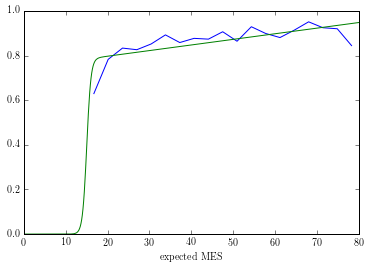

In [182]:
run_analysis((5300.0, 6000.0), (40, 80))

M-dwarfs:

Selected 2386 targets after cuts
Selected 8 KOIs after cuts
Computing mean completeness...
0.306 ± 0.108


(0.30565279427373704,
 0.1080645817597881,
 8,
 26.173488840528467,
 array([ 0.00435328,  0.64716674]))

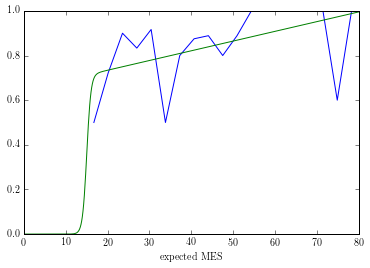

In [185]:
run_analysis((2400.0, 3900.0), (20, 40))